In [1]:
#general

import pandas as pd
import numpy as np
import os
import pickle
import time
import sys


import tensorflow as tf

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import reset_graph

from functools import partial

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond


#For parsing records once written
from Utilities.set_record_parser import build_set_dataset
from Utilities.set_record_parser import get_file_lists
from Utilities.models import log_dir_build

c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup Directories 

Here we are going to get the files needed to do the project

In [2]:
#Locate Neccesary Files
#Get Imageanet Label and Record Location
labels_file = "D:/Machine_Learning/Datasets/ImageNet_2012/labels.txt"
tf_record_directory =  'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records'

#Make 
class_file = open(labels_file,'r')
label_file = class_file.read().split('\n')
class_file.close()

In [3]:
# Import location of TF_Records
train_list, val_list = get_file_lists(tf_record_directory)
train_list

['D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00000-of-00002',
 'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00001-of-00002']

# Design Neural Network

The following provides the code to import and use the TF_Records for the set project

In [4]:
#directory for logs in training
set_net_logs = 'D:/AI/models/set_project/logs'
#model_path = log_dir_build(set_net_logs, "set_project")
model_path = 'D:/AI/models/set_project/logs/set_project-run-20190306174848/'

#directory for all the models saved during training
set_net_model = 'D:/AI/models/set_project/model/' + 'set_project'
set_net_model_best = 'D:/AI/models/set_project/model/' + 'set_project_best'

In [5]:
def deep_set_layer(input_code, input_size, condense_size, set_size=3, layer_name='default', activation_func=tf.nn.sigmoid):
    
    learned_transform = tf.get_variable(layer_name + '_transform', shape=[input_size,condense_size], 
                                        trainable=True, initializer=tf.contrib.layers.variance_scaling_initializer()) 
    batched_transform = tf.broadcast_to(learned_transform, [tf.shape(input_code)[0], input_size, condense_size])
    transform_layer = tf.matmul(input_code, batched_transform)
    activation = activation_func(transform_layer)
    
    
    lambda_1 = tf.get_variable(layer_name + "_lambda", [condense_size], trainable=True, dtype=tf.float32, initializer=tf.initializers.random_normal(mean=1))
    lambda_1_transformed = tf.broadcast_to(lambda_1, [set_size, condense_size])
    multipy_pairwise = tf.broadcast_to(lambda_1_transformed, [tf.shape(input_code)[0], set_size, condense_size])
    
    sigma_1 = tf.abs(tf.get_variable(layer_name + "_sigma", [condense_size], trainable=True, dtype=tf.float32, initializer=tf.initializers.random_normal(mean=0)))
    sigma_1_tranformed = tf.broadcast_to(sigma_1, [tf.shape(input_code)[0], condense_size])
    

    # + sigma * mean(Data)
    max_pool_1 = tf.reduce_mean(activation, axis=1)
    sum_term = tf.multiply(sigma_1_tranformed, max_pool_1)
    sum_term_final = tf.expand_dims(sum_term, axis=1)  
    
    pre_activation_1 = tf.multiply(activation, multipy_pairwise) + sum_term_final
    layer_1 = activation_func(pre_activation_1)
    return layer_1

In [6]:
reset_graph()

#Placeholder for choosing input, epochs, batches, and datasets at runtime
number_of_classes = 100
learning_rate_class = .1
dropout_rate = 0.2
set_size = 3

with tf.name_scope('Data_Retrieval'):
    filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
    batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
    num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
    training = tf.placeholder_with_default(True, shape=(), name = 'training')
    handle = tf.placeholder(tf.string, shape=[], name="Dataset")
    code_size = 2048

    training_set = build_set_dataset(True, filename, code_size, set_size, batch_size, num_epochs, num_parallel_calls=8)
    validation_set = build_set_dataset(False, filename, code_size, set_size, batch_size, num_epochs, num_parallel_calls=8)

    train_iterator = training_set.make_initializable_iterator()
    val_iterator = validation_set.make_initializable_iterator()

    iterator = tf.data.Iterator.from_string_handle(
        handle, training_set.output_types, training_set.output_shapes)
    next_element = iterator.get_next()
    code_data, class_data, file_data, uniques_data = next_element

    code = tf.placeholder_with_default(code_data, [None,3,2048])
    uniques = tf.placeholder_with_default(uniques_data, [None])

with tf.name_scope("BN_Layer_AE_Layers"):
    #Define initalizer and batch normalization layers
    bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
    he_init = tf.contrib.layers.variance_scaling_initializer()

with tf.name_scope("Set_Analyzer"):
    #the network for generating output of our set
    code_size = 2048
    n_layer_1 = 1000
    n_layer_2 = 500
    n_layer_3 = 250
    n_final_layer = 100
    deep_activation = tf.nn.relu
    
    
    with tf.name_scope('Deep_Sets'):
        batch_item = tf.cast(batch_size, tf.int32)
        input_before = tf.cast(code, tf.float32)
        
        with tf.name_scope('DeepSet_Layer_1'):
            #1000
            deep_1 = deep_set_layer(input_before, code_size, n_layer_1, set_size=3, layer_name='Deep_One', activation_func=deep_activation)

        with tf.name_scope('DeepSet_Layer_2'):
            #500
            deep_2 = deep_set_layer(deep_1, n_layer_1, n_layer_2, set_size=3, layer_name='Deep_Two', activation_func=deep_activation)
            
        with tf.name_scope('DeepSet_Layer_3'):
            #250
            deep_3 = deep_set_layer(deep_2, n_layer_2, n_layer_3, set_size=3, layer_name='Deep_Three', activation_func=deep_activation)
            
        with tf.name_scope('Final_Deep_Pool'):
            #250
            final_deep_layer = tf.reduce_sum(deep_3, 1)
            
            
    with tf.name_scope('Dense_Layers_Classification'):      
        
        with tf.name_scope("Class_Hidden_Layer_1"):
            #100
            hidden1_cat = tf.layers.dense(final_deep_layer, n_final_layer, name="hidden1_cat", kernel_initializer=he_init)
            hidden1_drop = tf.layers.dropout(hidden1_cat, dropout_rate, training=training)
            hidden1_cast = tf.cast(hidden1_drop, tf.float32)
            bn1_cat = bn_batch_norm_layer(hidden1_cast)
            bn1_act_cat = tf.nn.relu(bn1_cat)  
        
        
        with tf.name_scope("Final_Layer"): 
            #100
            logits_before_bn = tf.layers.dense(bn1_act_cat, n_final_layer, name="outputs")
            logits = bn_batch_norm_layer(logits_before_bn, name="logits")
            conditionals = tf.nn.sigmoid(logits, name="Conditionals")
            softmax = tf.nn.tanh(tf.nn.relu(logits))
            classes_guess = tf.round(softmax, name='Class_Guess')
            
        with tf.name_scope("loss"):
                cast_class = tf.cast(class_data, tf.int32)
                one_hot = tf.one_hot(cast_class, number_of_classes)
                summed_hot = tf.reduce_sum(one_hot, axis=1)
                correct_class = tf.round(tf.tanh(summed_hot))
                """
                number_in_set = tf.constant([set_size])
                divide = tf.cast(tf.tile(number_in_set, [n_final_layer]), tf.float32)
                correct_class = tf.divide(summed_hot, divide)
                """
                
                #loss_cat = tf.losses.softmax_cross_entropy(correct_class,softmax)
                #loss_cat = tf.losses.mean_squared_error(correct_class, softmax)
                loss_cat = tf.losses.sigmoid_cross_entropy(multi_class_labels=correct_class, logits=logits)   
                loss_summary_cat = tf.summary.scalar('loss_summary_cat', loss_cat)
                
        with tf.name_scope("eval_cat"):
            class_closeness = classes_guess - correct_class
            batch_clossness = tf.expand_dims(tf.reduce_sum(tf.abs(class_closeness), axis=1),1)
            perfect = tf.broadcast_to(tf.constant([1.00]),[tf.shape(classes_guess)[0],1]) 
            class_accuracy = tf.reduce_mean(perfect - tf.nn.tanh(tf.nn.relu(batch_clossness)), name='Class_Accuracy')
            accuracy_summary_class = tf.summary.scalar('accuracy_summary_class', class_accuracy)
            
        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False, name='global_step')
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            deep_train = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

            with tf.control_dependencies(extra_update_ops):
                with tf.control_dependencies(deep_train):
                    training_op_class = optimizer.minimize(loss_cat, global_step=global_step)
                
    with tf.name_scope('Unique_Identify'):
        n_unq_1 = 100
        n_unq_2 = 10
        n_unq_final = 2
        
        with tf.name_scope('DeepSet_Unq_Layer_1'):
            #500 Output
            deep_unq_1 = deep_set_layer(deep_1, n_layer_1, n_layer_2, set_size=3, layer_name='Deep_Unq_One', activation_func=deep_activation)
            
        with tf.name_scope('DeepSet_Unq_Layer_2'):
            #250 Output
            deep_unq_2 = deep_set_layer(deep_unq_1, n_layer_2, n_layer_3, set_size=3, layer_name='Deep_Unq_Two', activation_func=deep_activation)
            
        with tf.name_scope('Final_Unq_Deep_Pool'):
            #250 Output
            final_unq_deep_layer = tf.reduce_sum(deep_unq_2, 1)
            
        with tf.name_scope("Unq_Hidden_Layer_1"):
            #100 Output
            hidden1_unq = tf.layers.dense(final_unq_deep_layer, n_unq_1, name="hidden1_unq", kernel_initializer=he_init)
            hidden1_drop_unq = tf.layers.dropout(hidden1_unq, dropout_rate, training=training)
            hidden1_cast_unq = tf.cast(hidden1_drop_unq, tf.float32)
            bn1_cat_unq = bn_batch_norm_layer(hidden1_cast_unq)
            bn1_act_cat_unq = tf.nn.relu(bn1_cat_unq)  
            
        with tf.name_scope("Unq_Hidden_Layer_2"):
            #10 Output
            hidden2_unq = tf.layers.dense(bn1_act_cat_unq, n_unq_2, name="hidden2_unq", kernel_initializer=he_init)
            hidden2_drop_unq = tf.layers.dropout(hidden2_unq, dropout_rate, training=training)
            bn2_cat_unq = bn_batch_norm_layer(hidden2_drop_unq)
            bn2_act_cat_unq = tf.nn.relu(bn2_cat_unq)  
        
        
        with tf.name_scope("Final_Layer_unq"): 
            #Get softmax
            logits_before_bn_unq = tf.layers.dense(bn1_act_cat, n_unq_final, name="outputs_unq")
            logits_unq = bn_batch_norm_layer(logits_before_bn_unq, name="logits_unq")
            softmax_unq = tf.nn.softmax(logits_unq, name="final_soft_max_unq")
            
            
        with tf.name_scope("Unique_loss"):
            #0 class is different, 1 is the same
            select = tf.not_equal(uniques, tf.constant([1], dtype=tf.int32))
            zeros = tf.zeros_like(uniques, dtype=tf.int32)
            ones = tf.ones_like(uniques, dtype=tf.int32)
            labels = tf.squeeze(tf.where(select, zeros, ones), name='Unq_Labels')
            
            
            #Get cross entropy from labels
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_unq)
            loss_unq = tf.reduce_mean(xentropy, name="loss_unq")
            loss_summary_unq = tf.summary.scalar('loss_summary_unq', loss_unq)
            
        with tf.name_scope("eval_unq"):
            correct = tf.nn.in_top_k(logits_unq, labels, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
                
        with tf.name_scope("unique_train"):
            global_step_unique = tf.Variable(0, trainable=False, name='global_step_unique')
            optimizer_unq = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops_unq = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(extra_update_ops_unq):
                with tf.control_dependencies(deep_train):
                    training_op_unq = optimizer_unq.minimize(loss_unq, global_step=global_step_unique)
            

init = tf.global_variables_initializer()    
saver_total = tf.train.Saver(name="Full_Graph")

In [ ]:
#Write Graph to log directory
#filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [ ]:
#Initialize the network
"""
with tf.Session() as sess:
    init.run()
    saver_total.save(sess, set_net_model)
    saver_total.save(sess, set_net_model_best)
"""    

In [7]:
batch = 30
epochs = 1
with tf.Session() as sess:
    #init.run()
    #initialize iterator
    saver_total.restore(sess, set_net_model)
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    
    p,b = sess.run([perfect, class_accuracy], feed_dict={handle: train_handle})

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project/model/set_project


In [ ]:
print(model_path)

# Train the Network

Train the network to both generate conditioning for the network and also classify the type of set

In [ ]:
epochs = 2000
steps_between_test_save = 1
batch = 30
train_size = 64000
#all_data_steps = np.int(np.floor(train_size/batch))
all_data_steps = 100
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver_total.restore(sess, set_net_model)
    
    #Set up the global steps
    step = 1
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op_class, training_op_unq], feed_dict={handle: train_handle, batch_size: batch})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0) :
            loss_sum, loss_val, loss_un, loss_un_val, acc_sum, acc_class = sess.run([loss_summary_cat, loss_cat, loss_summary_unq, loss_unq, accuracy_summary, accuracy_summary_class], 
                                                   feed_dict = {handle: val_handle ,training: False, batch_size: batch})
            filewriter.add_summary(loss_sum, step)
            filewriter.add_summary(loss_un, step)
            filewriter.add_summary(acc_sum, step)
            filewriter.add_summary(acc_class, step)
            print("Epoch: " + str(step) + " Class Loss: " + str(loss_val) + " Unique Loss: " + str(loss_un_val))
            if lowest_loss > loss_val:
                saver_total.save(sess, set_net_model_best)
                lowest_loss = loss_val
            saver_total.save(sess, set_net_model)
        step = step + 1
            
    #Finish the final Model
    saver_total.save(sess, set_net_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

# Test the Training

Here we will see how the network performs after training

In [12]:
batch = 30
epochs = 100
num_iter = 200
with tf.Session() as sess:
    saver_total.restore(sess, set_net_model)
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    
    right, guess, acc, cond, ims, cc = sess.run([correct_class, classes_guess, class_accuracy, conditionals, file_data, code_data], feed_dict={handle: val_handle, training: False})

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project/model/set_project


In [9]:
#Get final parameter count
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(total_parameters)

3365136


In [13]:
item_number = 3

In [14]:
ims[item_number]

b'ILSVRC2012_val_00041840.JPEG,ILSVRC2012_val_00042357.JPEG,ILSVRC2012_val_00043067.JPEG,'

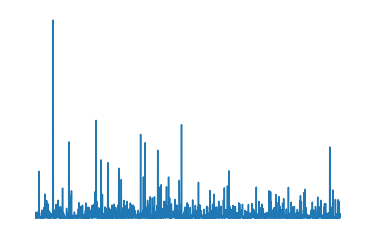

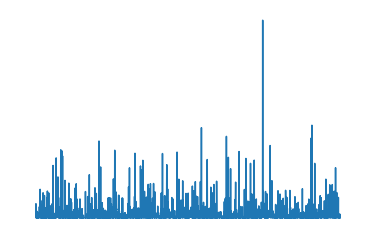

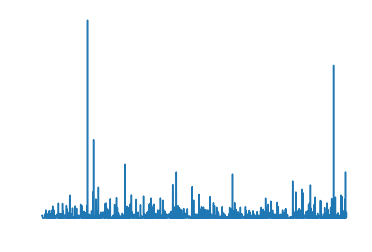

In [16]:
core_code = cc[item_number]
for i in core_code:
    from matplotlib import pyplot as plt
    plt.plot(i)
    plt.axis('off')
    plt.show()

In [17]:
in_set = np.where(right[item_number] == 1)[0]
for i in in_set:
    print('Array_Position: ' + str(i)  + ' Class_Label: ' + label_file[i])
right[item_number]

Array_Position: 2 Class_Label: Siberian_husky
Array_Position: 53 Class_Label: colobus
Array_Position: 57 Class_Label: coyote


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [18]:
in_set = np.where(guess[item_number] == 1)[0]
for i in in_set:
    print('Array_Position: ' + str(i)  + ' Class_Label: ' + label_file[i])
guess[item_number]

Array_Position: 2 Class_Label: Siberian_husky
Array_Position: 53 Class_Label: colobus
Array_Position: 57 Class_Label: coyote


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
acc

In [19]:
cond[item_number][2]

0.99992514

# Network Demonstration

Here we are going to show running the bones of the network and look a the training data 

In [ ]:
with tf.Session() as sess:
    #Initialize Train and validation iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: 1, num_epochs:1})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 1, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())

    test_code, test_class, test_file, test_unique = sess.run([code, class_data, file_data, uniques], feed_dict={handle: val_handle,training: False})

In [ ]:
#Show codes from single example
for i in range(0,3):
    X_test = test_code[0][i]
    x_val = X_test

    from matplotlib import pyplot as plt
    plt.plot(x_val)
    plt.axis('off')
    plt.show()

In [ ]:
#Show class for each item in set
for i in range(0,3):
    X_test = test_class[0][i]
    print('Class: ' + str(X_test) + ' Label: ' + labels[X_test])

In [ ]:
#Show what images the codes came from
print(test_file)

In [ ]:
#Show how many unitque Items are in the set
test_unique[0]